In [24]:
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import requests
import numpy as np
import pandas as pd
import json
import seaborn as sb
from matplotlib import pyplot as plt
from matplotlib import rcParams

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sb

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [25]:
sample=pd.read_csv('/home/codonnell/tutors/tutmain/all_tutors.csv')
sample = sample.drop(['Unnamed: 0', 'Unnamed: 0.1'],axis=1)
sample = sample.drop_duplicates()
sample = sample.drop_duplicates(subset='@id')
sample.head()

,@context,@type,@id,paymentAccepted,currenciesAccepted,description,priceRange,image,url,name,...,background_check,date_background_passed,education,sunday,monday,tuesday,wednesday,thursday,friday,saturday
0,http://schema.org,ProfessionalService,https://www.wyzant.com/Tutors/CA/Los_Angeles/7...,"Credit card, Paypal",USD,Fun Experienced Tutor!,60.0,https://dj1hlxw0wr920.cloudfront.net/userfiles...,https://www.wyzant.com/Tutors/CA/Los_Angeles/7...,Soraya O. Tutoring,...,1,\n\nBackground check passed on 8/19/2013\n,"['\n Paul Valery, france\n ...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F...","[False, False, False, False, False, False, Fal...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F..."
1,http://schema.org,ProfessionalService,https://www.wyzant.com/Tutors/CA/Beverly_Hills...,"Credit card, Paypal",USD,"Math, Writing and Econ Specialist, 8+ Years Tu...",75.0,https://dj1hlxw0wr920.cloudfront.net/userfiles...,https://www.wyzant.com/Tutors/CA/Beverly_Hills...,Patrick A. Tutoring,...,1,\n\nBackground check passed on 9/24/2015\n,['\n University of Florida\...,"[True, True, True, True, False, False, False, ...","[True, True, True, True, False, False, False, ...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F...","[True, True, True, True, True, False, False, F...","[False, False, False, False, False, False, Fal..."
2,http://schema.org,ProfessionalService,https://www.wyzant.com/Tutors/CA/Valley_Villag...,"Credit card, Paypal",USD,Top-Rated Test Prep (SAT / ACT / ISEE / HSPT) ...,95.0,https://dj1hlxw0wr920.cloudfront.net/userfiles...,https://www.wyzant.com/Tutors/CA/Valley_Villag...,Evan W. Tutoring,...,1,\n\nBackground check passed on 7/20/2017\n,['\n Tufts University\n ...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru...","[True, True, True, True, True, True, True, Tru..."
3,http://schema.org,ProfessionalService,https://www.wyzant.com/Tutors/CA/Tarzana/7614535/,"Credit card, Paypal",USD,Congratulations to my students entering Harvar...,95.0,https://dj1hlxw0wr920.cloudfront.net/userfiles...,https://www.wyzant.com/Tutors/CA/Tarzana/7614535/,William R. Tutoring,...,1,\n\nBackground check passed on 4/13/2015\n,['\n Harvard College\n ...,"[False, False, False, False, False, False, Fal...","[True, True, False, False, False, False, False...","[True, True, True, True, True, True, False, Fa...","[True, True, True, True, True, True, False, Fa...","[True, True, True, True, True, True, False, Fa...","[False, False, False, True, True, True, False,...","[True, True, True, True, True, True, False, Fa..."
4,http://schema.org,ProfessionalService,https://www.wyzant.com/Tutors/CA/Winnetka/7636...,"Credit card, Paypal",USD,Master of Science in Education in Teaching /CA...,40.0,https://dj1hlxw0wr920.cloudfront.net/userfiles...,https://www.wyzant.com/Tutors/CA/Winnetka/7636...,Amal S. Tutoring,...,1,\n\nBackground check passed on 5/8/2015\n,['\n Lebanese American Univ...,[None],[None],[None],[None],[None],[None],[None]


In [26]:
len(sample)

3625

In [27]:
sample['priceRange'] = sample['priceRange'].apply(float)

In [28]:
def get_subject_list(sub_list):
    sub_dicts = json.loads(sub_list.replace("'",'"'))
    return [sub['name'] for sub in sub_dicts]

In [29]:
def listToString(s):
    str1 = " " 
    return (str1.join(s)) 

In [30]:
sample['subject_list'] = sample['makesOffer'].apply(get_subject_list)
sample['subject_list_joined'] = sample['subject_list'].apply(listToString)

In [31]:
sample['subject_list_joined'].iloc[0]

'Precalculus tutoring French tutoring European History tutoring Calculus tutoring Spanish tutoring'

In [32]:
stopWords = ['tutoring'] 

tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 20000,
    stop_words = stopWords
)
tfidf.fit(sample['subject_list_joined'])
text = tfidf.transform(sample['subject_list_joined'])

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


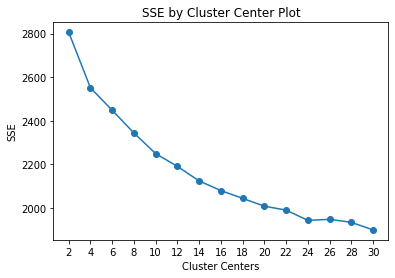

In [33]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 30)

In [61]:
clusters = MiniBatchKMeans(n_clusters=6, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

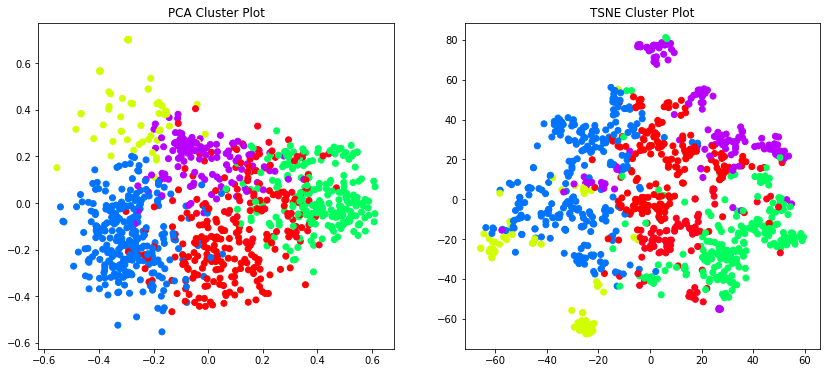

In [62]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=data.shape[0], replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=1000, replace=False)
    
    # choose only labels associated with subset of data 
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

In [37]:
text.shape[0]

3625

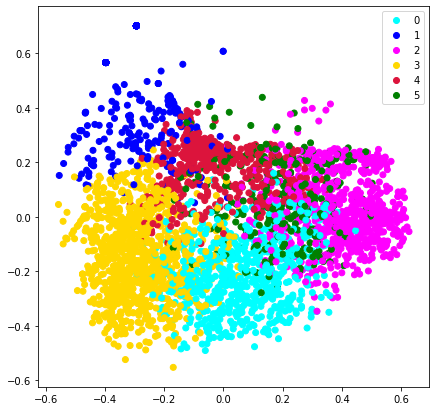

In [74]:
max_label = max(clusters)
max_items = np.random.choice(range(text.shape[0]), size=text.shape[0], replace=False)
    
pca = PCA(n_components=2).fit_transform(text[max_items,:].todense())
#tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(text[max_items,:].todense()))
    
idx = np.random.choice(range(pca.shape[0]), size=text.shape[0], replace=False)
label_sub = clusters[max_items]
label_sub = [2*i for i in label_sub[idx]]

x = pca[idx, 0]
y = pca[idx, 1]
#x = tsne[idx, 0]
#y = tsne[idx, 1]

rcParams['figure.figsize']=[7,7]
classes = list(set(clusters))
values = label_sub
colours = ListedColormap(['aqua','blue','fuchsia','gold','crimson','green'])
scatter = plt.scatter(x, y,c=values,cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.savefig('/home/codonnell/tutors/subj_clust.png')

In [64]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
writing,english,science,elementary,algebra,reading,sat,math,microsoft,act

Cluster 1
grammar,reading,writing,toefl,elementary,french,english,esl,esol,spanish

Cluster 2
sat,act,physics,prealgebra,geometry,trigonometry,precalculus,calculus,math,algebra

Cluster 3
sat,literature,proofreading,vocabulary,grammar,history,elementary,english,writing,reading

Cluster 4
programming,general,design,word,algebra,excel,accounting,adobe,computer,microsoft

Cluster 5
act,biochemistry,elementary,math,organic,science,physics,biology,algebra,chemistry


In [65]:
cluster_df = pd.DataFrame({'cluster': clusters, 'hourly_rate': sample['priceRange'].values})
cluster_df.head()

,cluster,hourly_rate
0,1,60.0
1,0,75.0
2,0,95.0
3,3,95.0
4,5,40.0


In [79]:
clus_rates = cluster_df.groupby('cluster')['hourly_rate'].mean()
clus_rates.index

Int64Index([0, 1, 2, 3, 4, 5], dtype='int64', name='cluster')

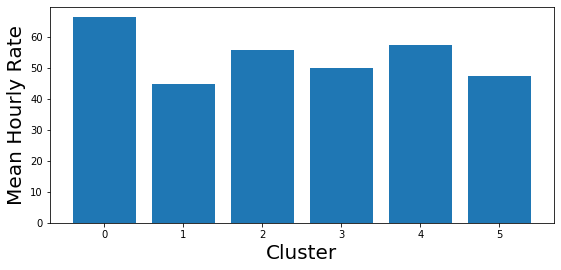

In [88]:
rcParams['figure.figsize']=[7,3]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = clus_rates.index
students = clus_rates.values
ax.bar(langs,students)
plt.xlabel('Cluster',fontsize=20)
plt.ylabel('Mean Hourly Rate',fontsize=20)
plt.savefig('/home/codonnell/tutors/clust_rates.png')

In [68]:
pd.Series(clusters).value_counts()

3    1026
2     742
0     680
4     558
1     313
5     306
dtype: int64

In [60]:
def cluster_var(text):
    
    for i in range(3,30):
        clusters = MiniBatchKMeans(n_clusters=i, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)
        cluster_df = pd.DataFrame({'cluster': clusters, 'hourly_rate': sample['priceRange'].values})
        print(cluster_df.groupby('cluster')['hourly_rate'].mean().to_frame()['hourly_rate'].std())
cluster_var(text)

5.936132112497179
5.653200483107013
7.299108693624601
7.890028711206092
5.628234572447005
5.8515027708776755
8.607905126076583
8.863758193386824
6.810338888222578
6.527061763518383
8.327696593616297
7.086545593292112
8.697218307952316
7.8574795682961875
8.651102843314943
8.892408676932455
10.10491592801804
9.202709239875578
9.880042782799658
9.206815570205809
9.617633231441568
9.375494096481766
10.588239247329186
9.464459678909503
9.073741039708507
10.003126642933116
10.018996838997655
